라이브러리

In [13]:
import pandas as pd
import numpy as np
from keras import backend as K
from keras.utils import *
from keras.models import load_model
from sklearn.preprocessing import *
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean, cosine, correlation

tank = 1
model_name = ['tank'+str(tank)+'_lstm_all', 'tank'+str(tank)+'_lstm_only-feed_no180', 'tank'+str(tank)+'_lstm_crop720_only-feed']

In [14]:
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [19]:
japonica_validation_food_supply_tb = pd.read_csv("./dataset/japonica_validation_food_supply_tb.csv")
japonica_validation_sensor_val = pd.read_csv("./dataset/japonica_validation_sensor_val_tb.csv")

japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

japonica_validation_sensor_val_tb = japonica_validation_sensor_val[japonica_validation_sensor_val['tank_id']==tank]

japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_validation_features = japonica_validation[feature_origin]

japonica_validation_features = japonica_validation_features.fillna(0)

japonica_validation_features.set_index('mea_dt', inplace=True)

japonica_validation_data = japonica_validation_features.sort_index()

japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

date_to_remove = pd.to_datetime('2021-08-03')
japonica_validation_data = japonica_validation_data.drop(japonica_validation_data[japonica_validation_data.index.date == date_to_remove.date()].index)

japonica_validation_features_X_a = japonica_validation_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_features_X_b = japonica_validation_data[['feed_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

C:\Users\rladn\AppData\Local\Temp\ipykernel_22448\824575710.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
C:\Users\rladn\AppData\Local\Temp\ipykernel_22448\824575710.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
C:\Users\rladn\AppData\Local\Temp\ipykernel_22448\824575710.py:14: 

In [20]:
japonica_validation_data.describe()

,tank_id,do_mg,do_temp,ph,orp,co2_mg,air_oxy,light_ma,feed_quantity,water_quantity
count,63360.0,63360.000000,63360.000000,63360.000000,63360.000000,63360.000000,63360.0,63360.000000,63360.000000,63360.000000
mean,1.0,8.780832,28.884437,5.365406,239.263090,25.413854,0.0,3.992503,0.010606,0.015141
std,0.0,1.220706,1.530924,0.447223,21.434609,7.902523,0.0,0.088106,0.316198,0.448958
min,1.0,4.400000,19.200000,3.990000,122.100000,0.000000,0.0,3.800000,0.000000,0.000000
25%,1.0,8.100000,28.500000,5.060000,228.900000,20.100000,0.0,3.900000,0.000000,0.000000
50%,1.0,8.700000,28.800000,5.330000,242.500000,27.700000,0.0,4.000000,0.000000,0.000000
75%,1.0,9.400000,30.100000,5.500000,252.700000,30.800000,0.0,4.000000,0.000000,0.000000
max,1.0,12.300000,32.100000,7.940000,303.300000,50.000000,0.0,4.900000,11.500000,16.100000


모델 평가

In [23]:
def grapeNEva(y_test, X_test_shape, feed):
    model = []
    array_index = 0
    
    for i in range(len(model_name)):
        model.append(load_model('./model/'+model_name[i]+'.h5', custom_objects={'r_squared': r_squared}))
    
    X_pred1 = model[0].predict(X_test_shape)
    X_pred1 = np.asarray(X_pred1, dtype=np.float64)
    X_pred1 = X_pred1.reshape((-1))
    
    X_pred2_result_array = np.asarray(feed)
    X_pred2_result_array = X_pred2_result_array.reshape((-1, 1, 1))
    X_pred2_result = model[1].predict(X_pred2_result_array)
    X_pred2_result = np.asarray(X_pred2_result, dtype=np.float64)
    X_pred2_result = X_pred2_result.reshape((-1))

    X_pred3_result = np.ones(len(feed))
    X_pred4_result = np.ones(len(feed))

    X_pred3_result_nomal = np.ones(len(feed))

    for i in range(len(feed)):
        if feed[i] > 0 :
            nomal_array = np.asarray(0)
            nomal_array = nomal_array.reshape((-1, 1, 1))
            nomal = model[1].predict(nomal_array)
            nomal = np.asarray(nomal, dtype=np.float64)
            nomal = nomal.reshape((-1))

            array_index = i
            X_pred2_array = np.asarray(feed[i])
            X_pred2_array = X_pred2_array.reshape((-1, 1, 1))
            X_pred2 = model[1].predict(X_pred2_array)
            X_pred2 = np.asarray(X_pred2, dtype=np.float64)
            X_pred2 = X_pred2.reshape((-1))[0]

            array_length = 720
            
            X_pred3_array = np.zeros(array_length)
            X_pred3_array[270] = feed[i]
            X_pred3_array = X_pred3_array.reshape((-1, array_length, 1))
            X_pred3 = model[2].predict(X_pred3_array)
            X_pred3 = np.asarray(X_pred3, dtype=np.float64)
            X_pred3 = X_pred3.reshape((-1))

            X_pred4 = X_pred3 * X_pred2 / nomal
            X_pred3_nomal = X_pred3 / nomal

            x = 0
            if array_index < 270 :
                x = 270 - array_index
                X_pred3 = X_pred3[x:]
                X_pred4 = X_pred4[x:]
                X_pred3_nomal = X_pred3_nomal[x:]


            X_pred3_result[array_index+x-270:array_index-270+x+len(X_pred3)] = X_pred3_result[array_index+x-270:array_index-270+x+len(X_pred3)] * X_pred3
            X_pred4_result[array_index+x-270:array_index-270+x+len(X_pred4)] = X_pred4_result[array_index+x-270:array_index-270+x+len(X_pred4)] * X_pred4
            X_pred3_result_nomal[array_index+x-270:array_index-270+x+len(X_pred3_nomal)] = X_pred3_result_nomal[array_index+x-270:array_index-270+x+len(X_pred3_nomal)] * X_pred3_nomal

    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('tank ' + str(tank) + ' sensor do')
    plt.legend(['sensor do'])
    plt.show()
    
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')
    plt.plot(y_test.index, X_pred1, color='red', label='prediction do')
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('tank ' + str(tank) + ' prediction do')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()

    final_predictions = X_pred1 * X_pred3_result_nomal
    
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')
    plt.plot(y_test.index, final_predictions, color='red', label='prediction do')
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('tank ' + str(tank) + ' final_predictions')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()

    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')
    plt.plot(y_test.index, X_pred1, color='orange', label='prediction do')
    plt.plot(y_test.index, final_predictions, color='red', label='final prediction do')
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('tank ' + str(tank) + ' final_predictions')
    plt.legend(['sensor do','prediction do','final predictions do','feed_quantity'])
    plt.show()

    y_test_reshape = np.asarray(y_test, dtype=np.float64)
    y_test_reshape = y_test_reshape.reshape((-1,1))

    euclidean_distance1 = euclidean(y_test_reshape.flatten(), X_pred1.flatten())
    euclidean_distance2 = euclidean(y_test_reshape.flatten(), final_predictions.flatten())
    print("Euclidean Distance\n", f"{euclidean_distance1:.3f}" ," → ", f"{euclidean_distance2:.3f}")

    cosine_similarity1 = 1 - cosine(y_test_reshape.flatten(), X_pred1.flatten())
    cosine_similarity2 = 1 - cosine(y_test_reshape.flatten(), final_predictions.flatten())
    print("Cosine Similarity\n", f"{cosine_similarity1:.3f}" ," → ", f"{cosine_similarity2:.3f}")

    correlation_coefficient1 = correlation(y_test_reshape.flatten(), X_pred1.flatten())
    correlation_coefficient2 = correlation(y_test_reshape.flatten(), final_predictions.flatten())
    print("Correlation Coefficient\n", f"{correlation_coefficient1:.3f}" ," → ", f"{correlation_coefficient2:.3f}")

    mse1 = mean_squared_error(y_test_reshape.flatten(), X_pred1.flatten())
    mse2 = mean_squared_error(y_test_reshape.flatten(), final_predictions.flatten())
    print("Mean Squared Error\n", f"{mse1:.3f}" ," → ", f"{mse2:.3f}")

    mae1 = mean_absolute_error(y_test_reshape.flatten(), X_pred1.flatten())
    mae2 = mean_absolute_error(y_test_reshape.flatten(), final_predictions.flatten())
    print("Mean Absolute Error\n", f"{mae1:.3f}" ," → ", f"{mae2:.3f}")

    correlation_coefficient1 = np.corrcoef(y_test_reshape.flatten(), X_pred1.flatten())[0, 1]
    correlation_coefficient2 = np.corrcoef(y_test_reshape.flatten(), final_predictions.flatten())[0, 1]
    print("Correlation Coefficient\n", f"{correlation_coefficient1:.3f}" ," → ", f"{correlation_coefficient2:.3f}")

1/1 [==============================] - 0s 96ms/step


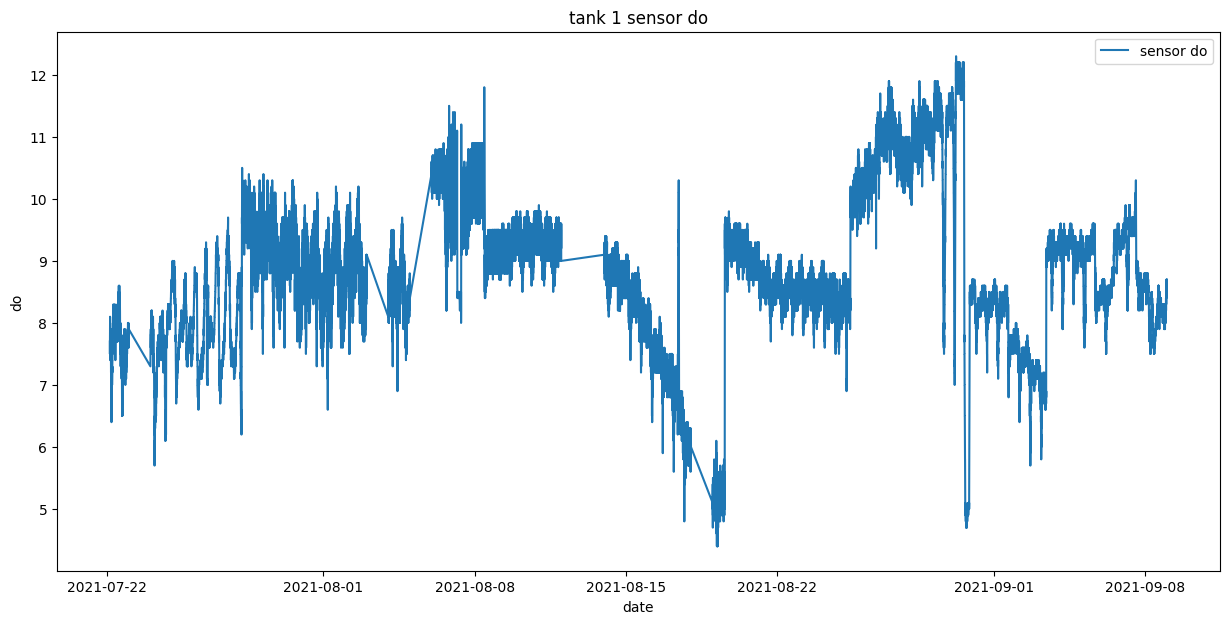

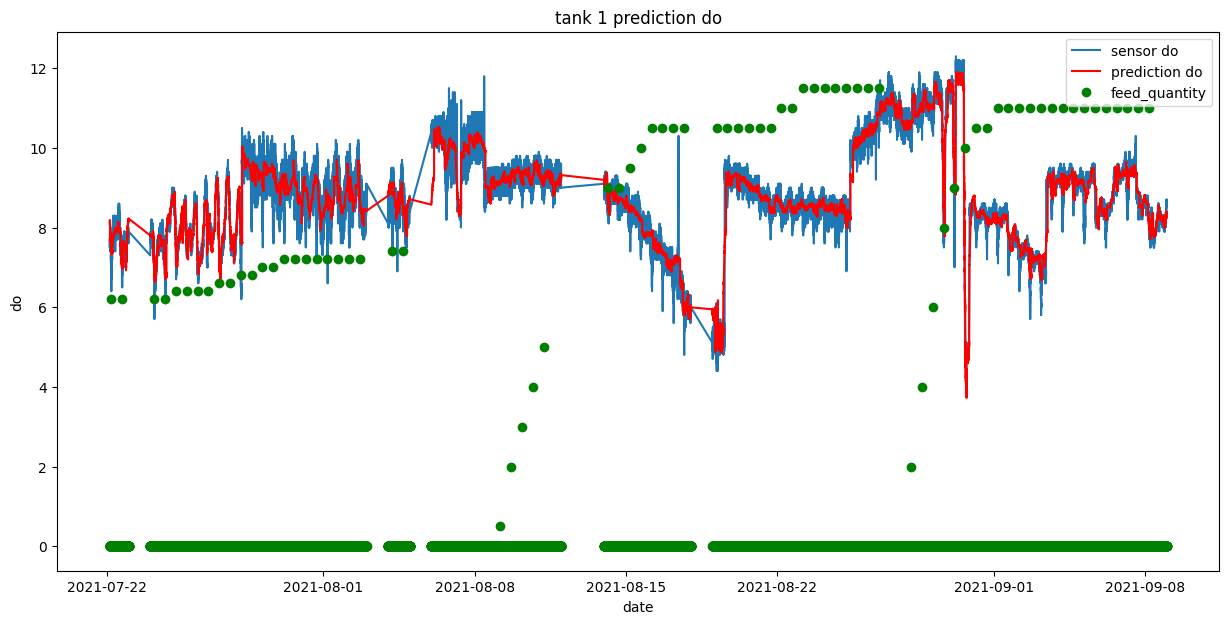

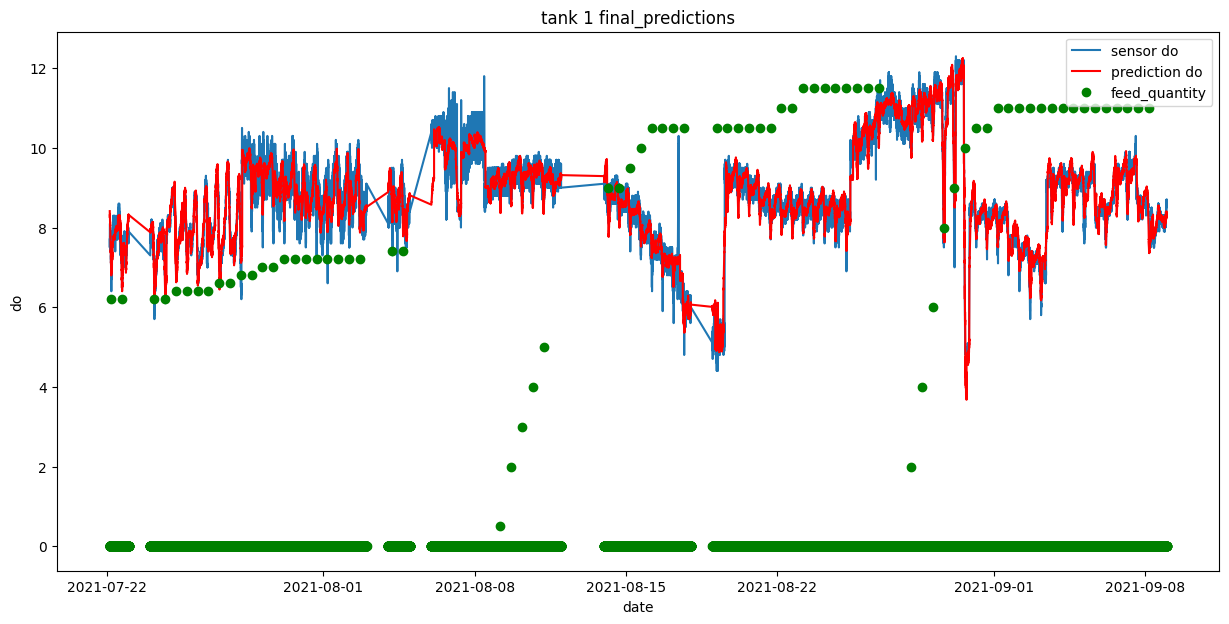

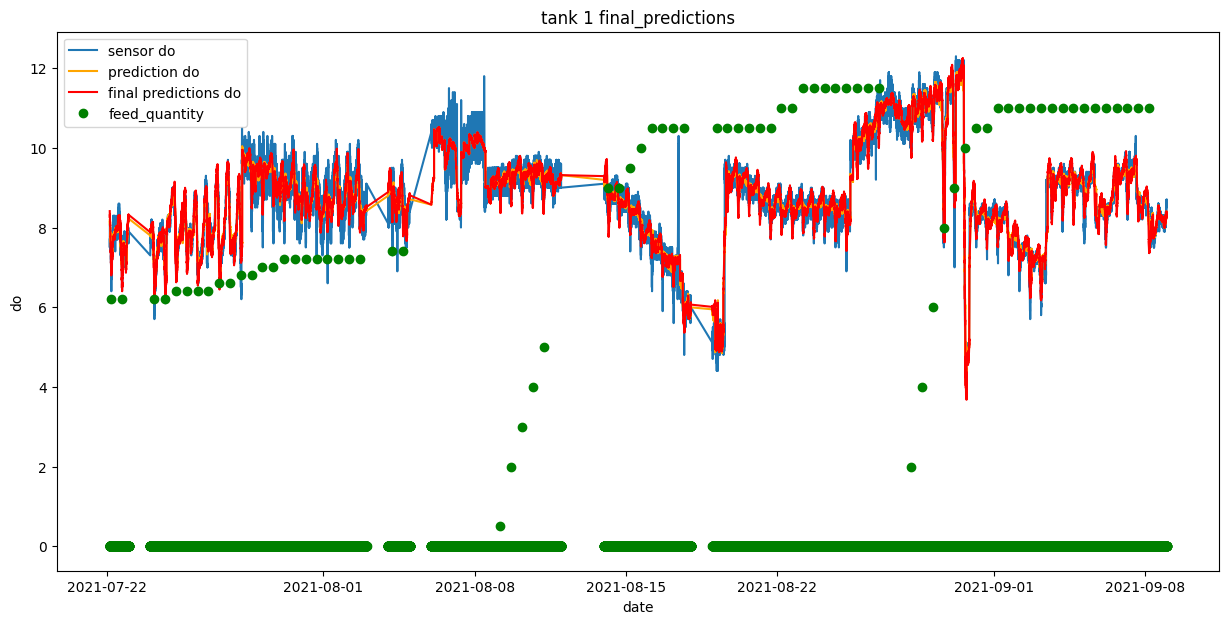

Euclidean Distance
 90.164  →  90.035
Cosine Similarity
 0.999  →  0.999
Correlation Coefficient
 0.045  →  0.044
Mean Squared Error
 0.132  →  0.131
Mean Absolute Error
 0.253  →  0.261
Correlation Coefficient
 0.955  →  0.956


In [24]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-09-08 23:59']

y_test = y_date[['do_mg']]

X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-09-08 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-09-08 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva(y_test, X_test_reshape1, feed)